In [1]:
import sys
sys.path.append('..')  # Add the parent directory to the system path
import constants  # to use the constants defined in the constants.py file
import os
from google import genai # to use the GenAI API
from pydantic import BaseModel# to enforce a .JSON output schema to the model
from ultralytics import YOLO
import supervision as sv
import cv2 

Found 7 images in the directory:


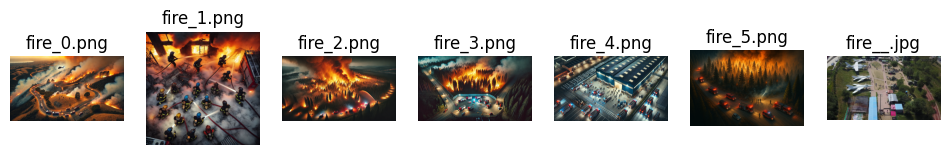

In [2]:
image_dir_path = '../Images'

image_paths = []

for filename in os.listdir(image_dir_path):
    if (filename.endswith(".jpg") or filename.endswith(".png")) and filename.startswith("fire"):
        image_path = os.path.join(image_dir_path, filename)
        image_paths.append(image_path)
        
image_paths.sort()
print(f"Found {len(image_paths)} images in the directory:")
titles=[
    os.path.basename(image_path)
    for image_path in image_paths[:len(image_paths)]
    ]               
images = [
    cv2.imread(str(image_path))
    for image_path in image_paths[:len(image_paths)]
    ]

sv.plot_images_grid(images=images, titles=titles,grid_size=(1,7))


image 1/1 /home/cardona/Tese/src/Projeto_0/main/../Images/fire_0.png: 384x640 3 persons, 5 cars, 1 airplane, 4 trucks, 943.2ms
Speed: 2.5ms preprocess, 943.2ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)


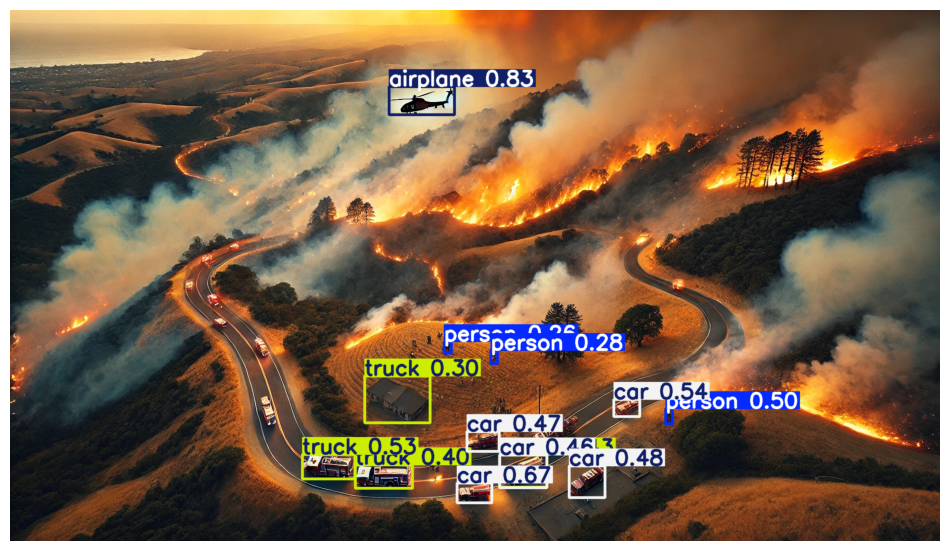

In [3]:
#Select image and read it
test_image_path = image_paths[0]
original_image = cv2.imread(test_image_path)

#select YOLO model and apply it to the image
model = YOLO('../yolo12x.pt')
test_result = model(test_image_path)

#Plot the object detection reults 
test_image = test_result[0].plot()
sv.plot_image(test_image)

Probabilities: 13
Final filtered boxes: 11


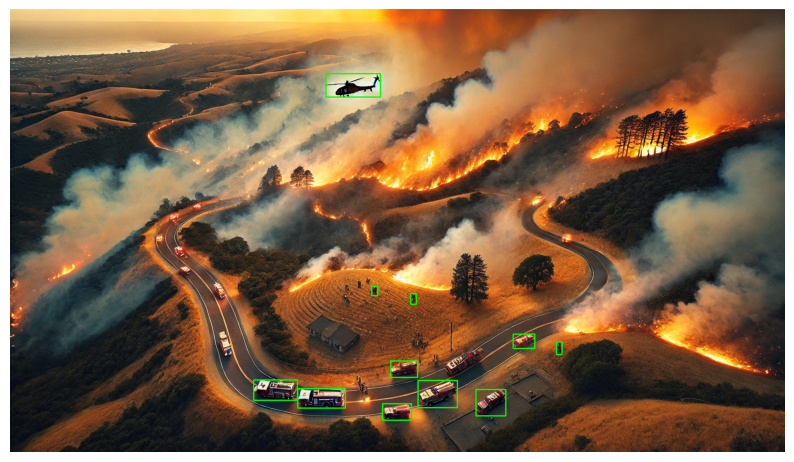

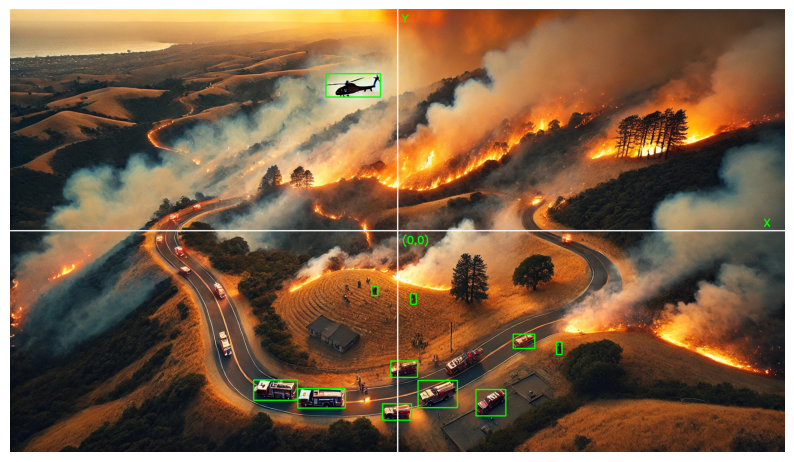

In [4]:
probabilities = test_result[0].boxes.conf

labels = [model.names.get(cls.item()) for cls in test_result[0].boxes.cls.int()]  

print("Probabilities:", len(probabilities))
filtered_boxes_with_probs = [
    (box,prob) for box, prob, label in zip(test_result[0].boxes.xyxy, probabilities, labels) if (prob >= 0.4) or (prob >= 0.2 and label =="person")
]

# Sort boxes by probability in descending order
filtered_boxes_with_probs.sort(key=lambda x: x[1], reverse=True)

# Remove overlapping boxes with lower probabilities
final_boxes = []
for i, (box1, prob1) in enumerate(filtered_boxes_with_probs):
    keep = True
    for j, (box2, prob2) in enumerate(final_boxes):
        x1_min, y1_min, x1_max, y1_max = box1
        x2_min, y2_min, x2_max, y2_max = box2

        # Calculate the intersection area
        inter_x_min = max(x1_min, x2_min)
        inter_y_min = max(y1_min, y2_min)
        inter_x_max = min(x1_max, x2_max)
        inter_y_max = min(y1_max, y2_max)

        if inter_x_min < inter_x_max and inter_y_min < inter_y_max:
            inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
            box1_area = (x1_max - x1_min) * (y1_max - y1_min)
            box2_area = (x2_max - x2_min) * (y2_max - y2_min)

            # Calculate the overlap ratio
            overlap_ratio = inter_area / min(box1_area, box2_area)

            # Remove if overlap is greater than or equal to 95%
            if overlap_ratio >= 0.95:
                keep = False
                break
    if keep:
        final_boxes.append((box1, prob1))

# Extract only the boxes
final_boxes = [box for box, prob in final_boxes]

print("Final filtered boxes:", len(final_boxes))

# Draw the final_boxes on the original image
for box in final_boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with the bounding boxes
sv.plot_image(original_image, size=(10, 10))

# Define the origin (0, 0) point at the center of the image
origin = (original_image.shape[1] // 2, original_image.shape[0] // 2)

# Draw the X-axis
cv2.line(original_image, (0, origin[1]), (original_image.shape[1], origin[1]), (255, 255, 255), 2)

# Draw the Y-axis
cv2.line(original_image, (origin[0], 0), (origin[0], original_image.shape[0]), (255, 255, 255), 2)

# Add labels for the axes
cv2.putText(original_image, 'X', (original_image.shape[1] - 50, origin[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 5), 2)
cv2.putText(original_image, 'Y', (origin[0] + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 5), 2)
cv2.putText(original_image, '(0,0)', (origin[0] + 10, origin[1] + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 5), 2)

# Display the image with the referential
sv.plot_image(original_image, size=(10, 10))

Unique labels: {'airplane', 'car', 'person', 'truck'}
Probabilities: tensor([0.8326, 0.6723, 0.5371, 0.5314, 0.5038, 0.4834, 0.4667, 0.4593, 0.4251, 0.4003, 0.2992, 0.2791, 0.2649])
Filtered boxes: [tensor([730.3784, 149.9936, 856.3353, 203.6854]), tensor([861.7526, 912.7859, 928.0922, 950.1466]), tensor([1163.2482,  751.5258, 1213.0928,  784.2812]), tensor([563.7427, 857.5699, 664.2701, 904.2443]), tensor([1263.1848,  769.7797, 1276.2589,  798.7699]), tensor([1077.4110,  879.9083, 1146.4156,  940.8370]), tensor([880.2814, 813.5172, 942.7376, 851.5177]), tensor([ 943.3732,  858.3616, 1034.3010,  921.0889]), tensor([ 943.3116,  858.6374, 1034.0645,  920.9835]), tensor([665.3167, 877.2725, 775.5118, 922.6175]), tensor([926.4548, 657.4853, 939.3386, 682.5521]), tensor([836.6148, 640.4979, 850.3424, 662.7590])]
Coordinates of the centers of the bounding boxes: [(-103, 336), (-2, -419), (292, -255), (-283, -368), (373, -271), (215, -397), (15, -320), (92, -377), (92, -377), (-176, -387), (3

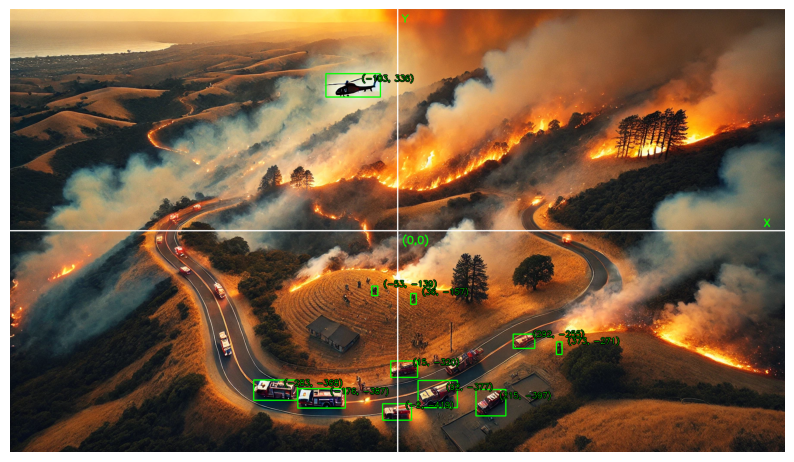

True

In [5]:
labels = [model.names.get(cls.item()) for cls in test_result[0].boxes.cls.int()]  
        
unique_labels = set(labels)
print("Unique labels:", unique_labels)

probabilities = test_result[0].boxes.conf
print("Probabilities:", probabilities)

# Filter out bounding boxes with probabilities lower than 0.5
filtered_boxes = []
filtered_boxes = [
    box for box, prob, label in zip(test_result[0].boxes.xyxy, probabilities, labels) if (prob >= 0.4) or (prob >= 0.2 and label =="person")
]

print("Filtered boxes:", filtered_boxes)

coordinates = []

for box in filtered_boxes:
    x1, y1, x2, y2 = map(int, box)
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Normalize coordinates with respect to the origin
    normalized_x = center_x - origin[0] # Normalize x-axis
    normalized_y = origin[1] - center_y  # Invert y-axis for Cartesian coordinates
    coordinates.append((normalized_x, normalized_y))
    
    text = f"({normalized_x}, {normalized_y})"
    #cv2.circle(original_image, (center_x, center_y), 10, (255, 0, 0), -1)
    # Draw the text with a black border and then the green text, to create an enhanced contrast 
    cv2.putText(original_image, text, (center_x+20, center_y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 4)
    cv2.putText(original_image, text, (center_x+20, center_y -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 5), 1)
    
print("Coordinates of the centers of the bounding boxes:", coordinates)

# Display the image with the centers drawn
sv.plot_image(original_image, size=(10, 10))
cv2.imwrite("Results/"+image_paths[0].split("/")[-1].split(".")[0]+"_coordinates.webp", original_image)

In [ ]:
# Create a list of tuples with the label, probability, and coordinates
object_coordinates = [(label, round(float(probab),2), coord[0], coord[1]) for label, probab, coord in zip(labels, probabilities, coordinates) if probab >= 0.4 or (probab >= 0.2 and label == "person")]
print("Number of objects with coordinates:", len(object_coordinates))
print("Object coordinates:", object_coordinates)


import jsonschema
import json

objectschema = {
    "type": "object",
    "properties": {
        "objects": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "label": {"type": "string"},
                    "probability": {"type": "number"},
                    "x": {"type": "number"},
                    "y": {"type": "number"}
                },
                "required": ["label", "x", "y"]
            }
        }
    },
    "required": ["objects"]
}

# Prepare data in the required format
data = {
    "objects": [
        {"label": label, "probabilities": probab, "x": x, "y": y}
        for label, probab, x, y in object_coordinates
    ]
}

# Validate the data against the schema
jsonschema.validate(instance=data, schema=objectschema)

# Save the data to a JSON file
with open("Results/object_coordinates.txt", "w") as json_file:
    json.dump(data, json_file, indent=4)
    
# Print the JSON data
print(json.dumps(data, indent=4))
    
print("Object coordinates saved to object_coordinates.json")

Number of objects with coordinates: 11
Object coordinates: [('airplane', 0.83, -103, 336), ('car', 0.67, -2, -419), ('car', 0.54, 292, -255), ('truck', 0.53, -283, -368), ('person', 0.5, 373, -271), ('car', 0.48, 215, -397), ('car', 0.47, 15, -320), ('car', 0.46, 92, -377), ('truck', 0.43, 92, -377), ('truck', 0.4, -176, -387), ('person', 0.28, -53, -139)]
{
    "objects": [
        {
            "label": "airplane",
            "probabilities": 0.83,
            "x": -103,
            "y": 336
        },
        {
            "label": "car",
            "probabilities": 0.67,
            "x": -2,
            "y": -419
        },
        {
            "label": "car",
            "probabilities": 0.54,
            "x": 292,
            "y": -255
        },
        {
            "label": "truck",
            "probabilities": 0.53,
            "x": -283,
            "y": -368
        },
        {
            "label": "person",
            "probabilities": 0.5,
            "x": 373,
      

In [7]:
# Create the GenAI client and choose the model
client = genai.Client(api_key=constants.API_KEY)
model_name="gemini-2.5-pro-exp-03-25"

#Read the image and coordinates
for filename in os.listdir("Results"):
    if(filename.endswith(".webp")):
        image_path = os.path.join("Results", filename)
        print(f"Image path: {image_path}")
    if(filename.endswith(".txt")):
        coordinates_path = os.path.join("Results", filename)
        print(f"Coordinates path: {coordinates_path}")

#Upload the image and coordinates to GenAI
llm_image=client.files.upload(file=image_path)
print(f"Image uploaded: {llm_image}")

llm_coordinates=client.files.upload(file=coordinates_path)
print(f"Coordinates uploaded: {llm_coordinates}")

Image path: Results/fire_0_coordinates.webp
Coordinates path: Results/object_coordinates.txt
Coordinates path: Results/prompt_response_pair_image.txt
Image uploaded: name='files/44n7trdkxcin' display_name=None mime_type='image/webp' size_bytes=2334644 create_time=datetime.datetime(2025, 5, 5, 9, 24, 5, 551667, tzinfo=TzInfo(UTC)) expiration_time=datetime.datetime(2025, 5, 7, 9, 24, 5, 497015, tzinfo=TzInfo(UTC)) update_time=datetime.datetime(2025, 5, 5, 9, 24, 5, 551667, tzinfo=TzInfo(UTC)) sha256_hash='YzdjODExNmYwYmE4Mzk0M2NjNTViY2JkNTcwNmY1Mzk0OTZhMmVkN2UyODMwNWQ2OTJkNjg1YWI1NzczY2IxZQ==' uri='https://generativelanguage.googleapis.com/v1beta/files/44n7trdkxcin' download_uri=None state=<FileState.ACTIVE: 'ACTIVE'> source=<FileSource.UPLOADED: 'UPLOADED'> video_metadata=None error=None
Coordinates uploaded: name='files/5wh6356wc79t' display_name=None mime_type='text/plain' size_bytes=9946 create_time=datetime.datetime(2025, 5, 5, 9, 24, 7, 190627, tzinfo=TzInfo(UTC)) expiration_time=d

In [14]:
prompt = """
            You are a network engineer responsible for analyzing the feed you received from a drone and identify the needs of the users in the network.
            The image was pre-processed to identify the objects in the image and their coordinates. 
            Your role here is to analyze the detected objects and infer the needs of the users in the network. The output must be the throughput need per user in the network and a justification for this need.
            By default all the user througput needs must be low, having enough bandwidth to communicate with one another via radio or voice calls.

            You'll need to analyse each detection carefully and understand what each user's needs are likely to be.
            For example, if a object or a group of objects are very close to a fire, one can infer that those users need a more reliable connection and might need to be prioritized and more probably need to transmit heavy data, such as streaming a video or an image.
            On the other hand if the user in question does not appear to be in a througput demainding situation, then the througput need of the user can be classified as low or medium, and the justification for this classification may simply be a sentence, like "the user is not in a througput demanding situation" or "the user is not in an iminent dangerous situation".  One example of this not througput demanding situation is when the user is not on a iminent dangerous situation like a support firetruck that is further away from the fire, or a user that is not in a fire situation at all.

            Also you are given a .txt file under the name "object_coordinates.txt" that contains the coordinates of the objects detected in the image, which are also present in the image.
            In the end replace all the entrys of airplane, truck or car by two identical entries with a new label, "person" and all the other fields replicated.

            The output must be a JSON object with the following schema, this must be replicated for each user in the image:
            {
                total_users: 1, # the total number of users in the image, can more easily be obtained from the object_coordinates.txt file
                "user": [
                {
                    "label": "user_label", # this label can be found in the object_coordinates.txt file and is corresponding to the coordinates associated with the user
                    "x": 0.0, # the x coordinate of the user in the image, that his associated with the label
                    "y": 0.0, # the y coordinate of the user in the image, that his associated with the label
                    "throughput_need": "high", # the throughput need of the user, can be "high", "medium" or "low"
                    "througput_justification": "the justification of the throughput need of the user, can be "high", "medium" or "low"
                    "throughput_example_value": 5 # This value is expressed in Mbps
                }      
            }
        """

In [15]:
response = client.models.generate_content(
    model=model_name,
    contents=[llm_image, llm_coordinates, prompt],
    )

print(response.text)

```json
{
    "total_users": 21,
    "user": [
        {
            "label": "person",
            "x": -103.0,
            "y": 336.0,
            "throughput_need": "high",
            "througput_justification": "Inferred user in helicopter: Actively involved in aerial observation/firefighting operations near the fire zone, requires real-time data transmission (video, sensor data).",
            "throughput_example_value": 80.0
        },
        {
            "label": "person",
            "x": -103.0,
            "y": 336.0,
            "throughput_need": "high",
            "througput_justification": "Inferred user in helicopter: Actively involved in aerial observation/firefighting operations near the fire zone, requires real-time data transmission (video, sensor data).",
            "throughput_example_value": 80.0
        },
        {
            "label": "person",
            "x": -53.0,
            "y": -139.0,
            "throughput_need": "high",
            "througput_jus

In [10]:
with open("Results/prompt_response_pair_image.txt", "a") as file:
    file.write("Prompt:\n")
    file.write(prompt)
    file.write("\n\nResponse:\n")
    file.write(response.candidates[0].content.parts[0].text)
    file.write("\n\n======================================================================================================\n")
    file.close()

In [ ]:
#get the response from the conversation that can be found in the prompt_response_pair_sound.txt file
with open("Results/prompt_response_pair_image.txt", "r") as file:
    lines = file.read()
    start_index = lines.find("Response:") + len("Response:\n")
    end_index = lines.find("======================================================================================================")
    response_sound = lines[start_index:end_index].strip()
    print(response_sound)

```json
{
    "total_users": 18,
    "user": [
        {
            "label": "person",
            "x": -103.0,
            "y": 336.0,
            "throughput_need": "high",
            "througput_justification": "Inferred user in aerial vehicle: Actively involved in aerial observation/firefighting operations near the fire zone, likely requires real-time data transmission (video, sensor data).",
            "throughput_example_value": 100.0
        },
        {
            "label": "person",
            "x": -103.0,
            "y": 336.0,
            "throughput_need": "high",
            "througput_justification": "Inferred user in aerial vehicle: Actively involved in aerial observation/firefighting operations near the fire zone, likely requires real-time data transmission (video, sensor data).",
            "throughput_example_value": 100.0
        },
        {
            "label": "person",
            "x": -2.0,
            "y": -419.0,
            "throughput_need": "medium",
 

In [16]:
#Upload the image and coordinates to GenAI
llm_image_response=client.files.upload(file="Feed2last/response_image.txt")
print(f"Image uploaded: {llm_image_response}")

llm_sound_response=client.files.upload(file="Feed2last/response_audio.txt")
print(f"Coordinates uploaded: {llm_sound_response}")

Image uploaded: name='files/tz1gj1k1nggj' display_name=None mime_type='text/plain' size_bytes=7270 create_time=datetime.datetime(2025, 5, 5, 10, 26, 32, 928205, tzinfo=TzInfo(UTC)) expiration_time=datetime.datetime(2025, 5, 7, 10, 26, 32, 874138, tzinfo=TzInfo(UTC)) update_time=datetime.datetime(2025, 5, 5, 10, 26, 32, 928205, tzinfo=TzInfo(UTC)) sha256_hash='ZmRiMjFkMTE0YzVjN2I5YzQ2MGQyYzczYjU3OGQxYzY3YmE2ODUwMGQ5MDQ3ZTZiNmQ4YWQ0MzcxMDViNWE3Nw==' uri='https://generativelanguage.googleapis.com/v1beta/files/tz1gj1k1nggj' download_uri=None state=<FileState.ACTIVE: 'ACTIVE'> source=<FileSource.UPLOADED: 'UPLOADED'> video_metadata=None error=None
Coordinates uploaded: name='files/89stdl3vyj7t' display_name=None mime_type='text/plain' size_bytes=2267 create_time=datetime.datetime(2025, 5, 5, 10, 26, 34, 125318, tzinfo=TzInfo(UTC)) expiration_time=datetime.datetime(2025, 5, 7, 10, 26, 34, 67518, tzinfo=TzInfo(UTC)) update_time=datetime.datetime(2025, 5, 5, 10, 26, 34, 125318, tzinfo=TzInfo(U

In [18]:
prompt= """
            You are now a network enginner responsible for analysing the Service Level Specification (SLS) of the network.
            For this you are given two different SLS files, one that was generated by analysing the image and the other one that was generated by analysing the audio, provided by a drone.
            Your role here is to analyse the SLS files and combine them into a single SLS file, that contains and adapts the information of both SLS files.
            For example if the image one states that the user needs a low througput and the audio one states that the user needs a high througput, then the final SLS file must state that the user needs a high througput and the justification for this need.
            
            The output must be a JSON object with the following schema, this must be replicated for each user in the image:
            {
                total_users: 1, # the total number of users in the image, can more easily be obtained from the object_coordinates.txt file
                "user": [
                {
                    "label": "user_label", # this label can be found in the object_coordinates.txt file and is corresponding to the coordinates associated with the user
                    "x": 0.0, # the x coordinate of the user in the image, that his associated with the label
                    "y": 0.0, # the y coordinate of the user in the image, that his associated with the label
                    "throughput_need": "high", # the throughput need of the user, can be "high", "medium" or "low"
                    "througput_justification": "the justification of the throughput need of the user, can be "high", "medium" or "low"
                    "throughput_example_value": 5 # This value is expressed in Mbps
                }      
            }
            """

In [19]:
final_response = client.models.generate_content(
    model=model_name,
    contents=[llm_image_response, llm_sound_response, prompt],
    )

print(final_response.text)

```json
{
    "total_users": 19,
    "user": [
        {
            "label": "person",
            "x": -103.0,
            "y": 336.0,
            "throughput_need": "high",
            "throughput_justification": "User inferred in aerial vehicle (helicopter) actively observing/fighting fire, requires high throughput for real-time video/sensor data transmission.",
            "throughput_example_value": 20
        },
        {
            "label": "person",
            "x": -103.0,
            "y": 336.0,
            "throughput_need": "high",
            "throughput_justification": "User inferred in aerial vehicle (helicopter) actively observing/fighting fire, requires high throughput for real-time video/sensor data transmission.",
            "throughput_example_value": 20
        },
        {
            "label": "person",
            "x": -53.0,
            "y": -139.0,
            "throughput_need": "high",
            "throughput_justification": "Unit 4 on scene at active fire,